# Forecasting uncertainty using CatBoost with loss function RMSEwithUncertainty

- eviter repetition de formules (eg. upper, lower bound) --> 
- rendre plus lisible: eviter iloc()
- revoire conventions
- 

## References

https://catboost.ai/en/docs/references/uncertainty
https://arxiv.org/pdf/2006.10562.pdf


## Introduction to uncertainty with RMSEwithUncertainty loss function

There are two main sources of uncertainty: data uncertainty (also known as aleatoric uncertainty) and knowledge uncertainty (also known as epistemic uncertainty).

Data uncertainty arises due to the inherent complexity of the data, such as additive noise or overlapping classes. Importantly, data uncertainty cannot be reduced by collecting more training data.

Knowledge uncertainty arises when the model is given an input from a region that is either sparsely covered by the training data or far from the training data.

A single model trained with special parameter PosteriorSampling is divided into N several models — virtual ensembles, which return N predicted values when they are applied on documents.

In case when the model was trained with RMSEWithUncertainty loss-function an ensemble predicts a 

vector of means of the predicted values $a=(a_0,...,a_{N-1})$ and a vector of variances: $s=(s_0,...,s_{N-1})$.

- Data uncertainty: $\bar{s}$
 
- Knowledge uncertainty: $Var(a)=\frac{1}{N}\sum(a_i−\bar{a}_i)^2$

- Total uncertainty = Data uncertainty + Knowledge uncertainty.

Our aim is to look for a  correlation between uncertainty and errors. Knowing the total or the knowledge uncertainty, can we evaluate the performance of the forecasting model.

For this we will introduce a confidence score between 0 and 1, 1 meaning we are fully confident tht the predicted value is the true value.

## Utils

In [1]:
#hide
import os
import inspect
import pandas as pd
import numpy as np
import json
from io import BytesIO
from google.cloud import storage
import time
import datetime as dt
from datetime import timedelta
import warnings
import logging
from functools import reduce
from IPython.display import Image
import statistics
from statistics import NormalDist
from functools import wraps
import plotly.express as px

from catboost import CatBoostRegressor, Pool, cv

from dateutil.relativedelta import relativedelta
from copy import deepcopy

import matplotlib.pyplot as plt
import plotly.graph_objects as go

logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

The following versions of libraries have been used :

In [2]:
print('Pandas :',pd.__version__)
print('Numpy :',np.__version__)

Pandas : 1.3.4
Numpy : 1.20.3


### Loading preprocessed data

Different kind of features have been previously computed :

   - Time series features
   - Lags of the target variable (sales) and some variations of it (rolling means, aggregations)
   - Pricing features
   - Cumulative means of sales on different time frames and at various levels of aggregation
   - Encoding for all categorical variables

In [3]:
#IMPORTANT: where to find the data? 
# inside the project data-sandbox-fr on GCP, inside Google Cloud Storage
# in the bucket m5-forecast/camille-uncertainty-with-catboost
# you can use the folder prepared_data and prepared_macro_data

df = pd.read_pickle('prepared_data/M5_df.pkl')
df_macro = pd.read_pickle('prepared_macro_data/M5_df_macro.pkl')

# Catboost 

Recall that in case when the model was trained with RMSEWithUncertainty loss-function an ensemble predicts a vector of means of the predicted values $a=(a_0,...,a_{N-1})$ and a vector of variances: $s=(s_0,...,s_{N-1})$.
- Data uncertainty: $\bar{s}$
 
- Knowledge uncertainty: $Var(a)=\frac{1}{N}\sum(a_i−\bar{a}i)^2$

- Total uncertainty = Data uncertainty + Knowledge uncertainty.




In [4]:
df_macro['date']

0        2012-01-31
1        2012-02-01
2        2012-02-02
3        2012-02-03
4        2012-02-04
            ...    
480595   2016-06-15
480596   2016-06-16
480597   2016-06-17
480598   2016-06-18
480599   2016-06-19
Name: date, Length: 480600, dtype: datetime64[ns]

#### Idexing columns

In [5]:
print('Indexing columns:',df_macro.columns[:4])

Indexing columns: Index(['item_id', 'date', 'sales', 'release'], dtype='object')


#### Sales lag columns

In [6]:
print('Sales lag columns:', df_macro.columns[4:34])

Sales lag columns: Index(['sales_lag_days_8', 'sales_lag_days_9', 'sales_lag_days_10',
       'sales_lag_days_11', 'sales_lag_days_12', 'sales_lag_days_13',
       'sales_lag_days_14', 'sales_lag_days_15', 'sales_lag_days_16',
       'sales_lag_days_17', 'sales_lag_days_18', 'sales_lag_days_19',
       'sales_lag_days_20', 'sales_lag_days_21', 'sales_lag_days_22',
       'sales_lag_days_23', 'sales_lag_days_24', 'sales_lag_days_25',
       'sales_lag_days_26', 'sales_lag_days_27', 'sales_lag_days_28',
       'sales_lag_days_29', 'sales_lag_days_30', 'sales_lag_days_31',
       'sales_lag_days_32', 'sales_lag_days_33', 'sales_lag_days_34',
       'sales_lag_days_35', 'sales_lag_days_365', 'sales_lag_days_366'],
      dtype='object')


#### Pricing features columns

In [7]:
print('pricing features columns', df_macro.columns[35:48])

pricing features columns Index(['cum_mean_week_item_id', 'cum_mean_day_item_id',
       'cum_mean_month_item_id', 'diff_price_same_month_item',
       'diff_price_same_day_item', 'diff_price_same_item',
       'min_price_same_store_item', 'max_price_same_store_item',
       'mean_price_same_store_item', 'std_price_same_store_item',
       'nunique_price_same_store_item', 'price_norm', 'price_momentum'],
      dtype='object')


#### Cumulative means of sales on different time frames and at various levels of aggregation columns

In [8]:
print('Cumulative means of sales on different time frames and at various levels of aggregation columns:', df_macro.columns[48:-40])

Cumulative means of sales on different time frames and at various levels of aggregation columns: Index(['price_momentum_m', 'price_momentum_y', 'mean_8-14_days_sales',
       'mean_8-21_days_sales', 'mean_8-28_days_sales', 'mean_8-35_days_sales',
       'std_8-14_days_sales', 'std_8-35_days_sales', 'mean_15-21_days_sales',
       'mean_15-28_days_sales', 'mean_15-35_days_sales',
       'mean_15-42_days_sales', 'std_15-21_days_sales', 'std_15-42_days_sales',
       'mean_22-28_days_sales', 'mean_22-35_days_sales',
       'mean_22-42_days_sales', 'mean_22-49_days_sales',
       'std_22-28_days_sales', 'std_22-49_days_sales', 'mean_29-35_days_sales',
       'mean_29-42_days_sales', 'mean_29-49_days_sales',
       'mean_29-56_days_sales', 'std_29-35_days_sales', 'std_29-56_days_sales',
       'date_avg_sales_lag_days_1', 'date_avg_sales_lag_days_8',
       'date_avg_sales_lag_days_15', 'date_avg_sales_lag_days_22',
       'date_avg_sales_lag_days_29', 'date_avg_sales_lag_days_100',
       

#### Encoded date columns 

In [9]:
print('Encoded date columns:', df_macro.columns[-40:])

Encoded date columns: Index(['day', 'week', 'month', 'year', 'dayofweek', 'weekend', 'dayofyear',
       'date_block_num_month', 'date_block_num_week', 'date_block_num_day',
       'OrthodoxChristmas', 'OrthodoxEaster', 'LaborDay', 'ValentinesDay',
       'PresidentsDay', 'MartinLutherKingDay', 'LentWeek2', 'Christmas',
       'NBAFinalsEnd', 'Chanukah End', 'VeteransDay', 'IndependenceDay',
       'LentStart', 'Pesach End', 'Mother's day', 'NBAFinalsStart',
       'MemorialDay', 'Thanksgiving', 'Eid al-Fitr', 'Father's day',
       'Halloween', 'EidAlAdha', 'Easter', 'StPatricksDay', 'ColumbusDay',
       'Ramadan starts', 'Purim End', 'Cinco De Mayo', 'SuperBowl', 'NewYear'],
      dtype='object')


## Train the model 

### Split data into train and test subdatasets

In [10]:
def train_test_split(df, target, date_column, split_day, end_day):
    split = dict()
    split['TRAIN'] = df.loc[df[date_column] <= split_day, date_column].unique()
    split['VALID'] = df.loc[(df[date_column] > split_day) & (df[date_column] <= end_day), date_column].unique()
    
    df = df.dropna(subset=[target])
    
    X_train = df.loc[df[date_column].isin(split['TRAIN'])].drop([target], axis=1)
    y_train = df.loc[df[date_column].isin(split['TRAIN'])][target]
    
    X_test = df.loc[df[date_column].isin(split['VALID'])].drop([target], axis=1)
    y_test = df.loc[df[date_column].isin(split['VALID'])][target]
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_macro,'sales', 'date', '2015-01-01 00:00:00' , '2016-05-01 00:00:00')

To train and test a CatBoost model, need to build a pool by specifying the categorical variables (here only 'item_id').

In [12]:
train_pool = Pool(X_train, y_train, cat_features=['item_id'])
val_pool = Pool(X_test, y_test, cat_features=['item_id'])

### Models with different seeds method
> Tutorial: https://blog.birost.com/a?ID=01800-e575a4fb-bcb6-42d4-8b3f-7db3ef27716c

We train 10 models that differ only by the seed, to compute the knowledge and data uncertainties.

In [13]:
def train_predict_model_M_seeds(train_pool, val_pool, X_test, num_samples=10):
    ens_preds = []

    for seed in range(num_samples):
        
        PARAMETERS =     {"loss_function" : "RMSEWithUncertainty"
                    , "random_seed" : seed
                    , "verbose" : 30
                    , "iterations" : 300
                    , "max_depth" : 8
                    , "l2_leaf_reg" : 1
                    , "learning_rate" : 0.1
                    , "task_type" : 'CPU'
                    , "devices" : '0:1'
                    , "thread_count" : -1
                    , "early_stopping_rounds" : 20
                    , "posterior_sampling": True
                    , "verbose": False}

        model = CatBoostRegressor(**PARAMETERS)

        model.fit(train_pool, eval_set=val_pool)
        ens_preds.append(model.predict(X_test))
    
    return ens_preds

In [14]:
preds_10 = train_predict_model_M_seeds(train_pool, val_pool, X_test, num_samples=10)

In [15]:
print('The output of the model has shape', (len(preds_10), len(preds_10[0]), len(preds_10[0][0])))

The output of the model has shape (10, 145800, 2)


The first column is the mean of predictions and the second column the variance of predictions (for each of the 10 models and for each of the 145800 different predictions).

In [16]:
# predicted values: mean of mean (first column) of predictions
mean_preds_10 = np.mean(preds_10, axis = 0)[:,0]

# data uncertainty: mean of variance (second column) of predictions
data_10 = np.mean(preds_10, axis = 0)[:,1]

# knowledge uncertainty: variance of mean (first column) predictions 
knowledge_10 = np.var(preds_10, axis = 0)[:,0] 

## Virtual ensemble 
> Tutorial: https://blog.birost.com/a?ID=01800-e575a4fb-bcb6-42d4-8b3f-7db3ef27716c

You can build an virtual ensemble from one model only and therefore it is computationally M times cheaper than the previous method.

How is the virtual ensemble built? 
The concept of a virtual ensemble enables generating an ensemble using only one model. This is possible since a CatBoost model is itself an ensemble of trees. However, in contrast to random forests formed by independent trees, the sequential nature of CatBoost models implies that all trees are dependent and individual trees cannot be considered as separate models. Hence, we use “truncated” sub-models of a single CatBoost model as elements of an ensemble, as illustrated in Figure 1.

In [17]:
def train_predict_model_virtual_ensemble(train_pool, val_pool, X_test, num_samples):

    SEED = 42
    PARAMETERS =     {"loss_function" : "RMSEWithUncertainty"
                    , "random_seed" : SEED
                    , "verbose" : 30
                    , "iterations" : 300
                    , "max_depth" : 8
                    , "l2_leaf_reg" : 1
                    , "learning_rate" : 0.1
                    , "task_type" : 'CPU'
                    , "devices" : '0:1'
                    , "thread_count" : -1
                    , "early_stopping_rounds" : 20
                    , "posterior_sampling": True
                    , "verbose": False}

    model = CatBoostRegressor(**PARAMETERS)

    model.fit(train_pool, eval_set=val_pool)
    
    preds = model.virtual_ensembles_predict(X_test, 
                                            prediction_type='TotalUncertainty', 
                                            virtual_ensembles_count=num_samples)
    
    return preds
    

In [18]:
preds_ve_10 = train_predict_model_virtual_ensemble(train_pool, val_pool, X_test, 10)

In [19]:
print('The model output is of the shape',preds_ve_10.shape)

The model output is of the shape (145800, 3)


Using the virtual ensemble method, the model directly returns the mean of predcitions (1st column), the computed knowledge uncertainty (2nd column) and the data uncertainty (3rd columns) for each of the 145800 different predictions. 

In [20]:
# mean values estimated by a virtual ensemble
mean_preds_ve_10 = preds_ve_10[:,0]

# knowledge uncertainty estimated by a virtual ensemble
knowledge_ve_10 = preds_ve_10[:,1] 

# data uncertainty estimated by a virtual ensemble
data_ve_10 = preds_ve_10[:,2]

## Quantile regression

> Tutorial: https://brendanhasz.github.io/2018/12/15/quantile-regression 

We will also test a method that computes the predictive intervals (say, 90%) directly thanks to the 5-th quantile (for the lower bound) and the 95-th quantile (for the upper bound). Instead of computing the confidence intervals based on the uncertainties, we use the quantiles that are computed thanks to the quantile loss function: 'Quantile:alpha=0.05'and 'Quantile:alpha=0.95', defined as: 
$$L_q(y,\hat{y})=(q−1) \sum_{i \in y_i < \hat{y}_i}{|y_i−\hat{y}_i|}+q\sum_{i \in y_i \geq \hat{y}_i}{|y_i−\hat{y}_i|}$$
for true values $y$, the predicted values $\hat{y}_i$, and a desired quantile $q$ (from 0 to 1).

In [100]:
def confidence_intervals_quantile(x, y, X_test, percentage):
    PARAMETERS = { "loss_function" : 'Quantile:alpha=0.05'
                  , "random_seed" : 42
                  , "verbose" : 30
                  , "iterations" : 300
                  , "max_depth" : 8
                  , "l2_leaf_reg" : 1
                  , "learning_rate" : 0.1
                  , "task_type" : 'CPU'
                  , "devices" : '0:1'
                  , "thread_count" : -1
                  , "early_stopping_rounds" : 20
                  , "posterior_sampling": True
                  , "verbose": False}
    
    # quantile for predictions (mean)
    gbrL = CatBoostRegressor(**PARAMETERS)
    gbrL.fit(x, eval_set = y)
    y_predL = gbrL.predict(X_test)

    PARAMETERS = { "loss_function" : 'Quantile:alpha=0.95'
                  , "random_seed" : 42
                  , "verbose" : 30
                  , "iterations" : 300
                  , "max_depth" : 8
                  , "l2_leaf_reg" : 1
                  , "learning_rate" : 0.1
                  , "task_type" : 'CPU'
                  , "devices" : '0:1'
                  , "thread_count" : -1
                  , "early_stopping_rounds" : 20
                  , "posterior_sampling": True
                  , "verbose": False}
    
    # quantile for predictions (mean)
    gbrH = CatBoostRegressor(**PARAMETERS)
    gbrH.fit(x, eval_set = y)
    y_predH = gbrH.predict(X_test)

    PARAMETERS = { "loss_function" : 'Quantile:alpha=0.5'
                  , "random_seed" : 42
                  , "verbose" : 30
                  , "iterations" : 300
                  , "max_depth" : 8
                  , "l2_leaf_reg" : 1
                  , "learning_rate" : 0.1
                  , "task_type" : 'CPU'
                  , "devices" : '0:1'
                  , "thread_count" : -1
                  , "early_stopping_rounds" : 20
                  , "posterior_sampling": True
                  , "verbose": False}
    
    # quantile for predictions (mean)
    gbr = CatBoostRegressor(**PARAMETERS)
    gbr.fit(x, eval_set = y)
    y_pred = gbr.predict(X_test)

    return y_pred, y_predL, y_predH

In [101]:
output = confidence_intervals_quantile(train_pool, val_pool, X_test, 0.9)

In [103]:
X_test_q = X_test[['item_id', 'date']]

X_test_q['truth'] = y_test
X_test_q['pred'] = output[0]
X_test_q['lower_bound'] = output[1]
X_test_q['upper_bound'] = output[2]

In [104]:
# Function to compute coverage of predictive interval
def coverage(y, yL, yH):
     return (100 / y.shape[0] *
             ((y>yL)&(y<yH)).sum())

In [105]:
# Compute coverage of the 90% interval
print('Coverage of 90%% predictive interval: %0.1f%%'
      % coverage(X_test_q['truth'], X_test_q['lower_bound'], X_test_q['upper_bound']))

Coverage of 90% predictive interval: 87.5%


# Results

### Performance metrics

Since the sum of the true values is displayed as infinit (even if there are no NaN values), we create a function to sum the values. This function will be used to compute the forecast accuracy and other metrics. 

In [107]:
def sum_valid(x):
    s=0
    for i in range(x.shape[0]):
        s+=x.iloc[i]
    return s

In [108]:
#accuracy
def accuracy_total(y_test,y_pred):
    s = sum_valid(y_test)
    accuracy = 1 - np.sum(np.absolute(y_test - y_pred)) / s
    return accuracy

In [109]:
def mean_valid(x):
    s=0
    for i in range(x.shape[0]):
        s+=x.iloc[i]
    return s/x.shape[0]

In [110]:
#RMSE
def rmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred) ** 2))

In [111]:
#NRMSE
def nrmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred) ** 2))/mean_valid(y_test)

In [112]:
X_test_ve = X_test[['item_id', 'date']]

X_test_ve["truth"] = y_test
X_test_ve["pred"] = mean_preds_ve_10
X_test_ve['knowledge'] = knowledge_ve_10
X_test_ve['data'] = data_ve_10
X_test_ve['total'] = knowledge_ve_10+data_ve_10

In [113]:
X_test_s = X_test[['item_id', 'date']]

X_test_s["truth"] = y_test
X_test_s["pred"] = mean_preds_10
X_test_s['knowledge'] = knowledge_10
X_test_s['data'] = data_10
X_test_s['total'] = knowledge_10+data_10

In [114]:
#Method 1: virtual ensemble method 
fa_day = accuracy_total(y_test,mean_preds_ve_10)
rmse_day = rmse(y_test, mean_preds_ve_10)
nrmse_day = nrmse(y_test, mean_preds_ve_10)

# table total accuracy and RMSE 
pd.DataFrame(
    [[fa_day], [rmse_day], [nrmse_day]], ["FA", "RMSE", "NRMSE"], ["Metric"]
).round(decimals=2)

#Method 2: multiple seeds method
fa_day2 = accuracy_total(y_test, mean_preds_10)
rmse_day2 = rmse(y_test, mean_preds_10)
nrmse_day2 = nrmse(y_test, mean_preds_10)

#Method 2: multiple seeds method
fa_day3 = accuracy_total(y_test, X_test_q['pred'])
rmse_day3 = rmse(y_test, X_test_q['pred'])
nrmse_day3 = nrmse(y_test, X_test_q['pred'])

# table total accuracy and RMSE 
pd.DataFrame(
    [[fa_day, fa_day2, fa_day3], [rmse_day, rmse_day2, rmse_day3], [nrmse_day, nrmse_day2, nrmse_day3]], ["FA", "RMSE", "NRMSE"], ["Virtual Ensembles", "Different seeds", "Quantile"]
).round(decimals=2)

,Virtual Ensembles,Different seeds,Quantile
FA,0.69,0.70,0.70
RMSE,7.88,7.77,7.89
NRMSE,0.62,0.61,0.62


## Define confidence scores 

Let's use a confidence score based on the 40 models used to compute the knowledge uncertainty:
- confidence score: $$score = 1 - \frac{Upper bound - Lower bound}{Forecast}$$
If the data follows a normal distribution and we assume that we want to get a $1 - \alpha $ confidence interval, we could simply use the confidence interval: $[\bar{X} - q_{\alpha} \frac{\sigma}{\sqrt{N}}; \bar{X} + q_{\alpha} \frac{\sigma}{\sqrt{N}}]$, where N is the number of models generated by posterior sampling (here 40) and $q_{\alpha}$ is the quantile of a standard normal distribution with probability $\alpha$: 
$$score = 1 - \frac{2 q_{\alpha}}{\sqrt{40}} \frac{\sigma}{Forecast}, \quad \sigma = \sqrt{\text{uncertainty}}$$
We set $\sigma = \sqrt{\text{uncertainty}}$ because the uncertainty is measured as a variance. 

For this time, let's compute the confidence scores, from the confidence intervals with a confidence level of 90%.

In [115]:
NormalDist(mu=0, sigma=1).inv_cdf(0.95)-NormalDist(mu=0, sigma=1).inv_cdf(0.05)

3.289707253902944

With NormalDist, we can generalise this method to any confidence level $\alpha$.

In [116]:
percentage=0.9
uncertainty = 'total'
number_models=10

lower_bound = (1-percentage)/2
upper_bound = 1-(1-percentage)/2
quantiles_diff = NormalDist(mu=0, sigma=1).inv_cdf(upper_bound)-NormalDist(mu=0, sigma=1).inv_cdf(lower_bound)

X_test_s['lower_bound'] = X_test_s['pred']-quantiles_diff/(2*np.sqrt(10))*np.sqrt(X_test_s[uncertainty])
X_test_s['upper_bound'] = X_test_s['pred']+quantiles_diff/(2*np.sqrt(10))*np.sqrt(X_test_s[uncertainty])
X_test_s['confidence_score_90'] = 1-quantiles_diff/np.sqrt(number_models)*np.sqrt(X_test_s[uncertainty])/X_test_s['pred']

X_test_s['inside_ci'] = (X_test_s['truth']>X_test_s['lower_bound'])&(X_test_s['truth']<X_test_s['upper_bound'])

In [117]:
percentage=0.9
uncertainty = 'total'
number_models=10

lower_bound = (1-percentage)/2
upper_bound = 1-(1-percentage)/2
quantiles_diff = NormalDist(mu=0, sigma=1).inv_cdf(upper_bound)-NormalDist(mu=0, sigma=1).inv_cdf(lower_bound)

X_test_ve['lower_bound'] = X_test_ve['pred']-quantiles_diff/(2*np.sqrt(10))*np.sqrt(X_test_ve[uncertainty])
X_test_ve['upper_bound'] = X_test_ve['pred']+quantiles_diff/(2*np.sqrt(10))*np.sqrt(X_test_ve[uncertainty])
X_test_ve['confidence_score_90'] = 1-quantiles_diff/np.sqrt(number_models)*np.sqrt(X_test_ve[uncertainty])/X_test_ve['pred']

X_test_ve['inside_ci'] = (X_test_ve['truth']>X_test_ve['lower_bound'])&(X_test_ve['truth']<X_test_ve['upper_bound'])

In [118]:
X_test_q['confidence_score_90'] = 1-(X_test_q['upper_bound']-X_test_q['lower_bound'])/X_test_q['pred']

X_test_q['inside_ci'] = (X_test_q['truth']>X_test_q['lower_bound'])&(X_test_q['truth']<X_test_q['upper_bound'])

#### Coverage rate: ratio of true values inside the confidence interval 

In [119]:
def plot_predictions_ci(X_test, percentage=0.9):
    
    agg = X_test

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=agg["date"], y=agg.truth, mode="lines", name='Ground truth', line=dict(color='#ff0066')))
    fig.add_trace(go.Scatter(x=agg["date"], y=agg['pred'], mode="lines", name='Prediction', line=dict(color='#002244')))    
    fig.add_trace(go.Scatter(x=agg["date"], y=agg['lower_bound'], mode="lines", name='lower bound', line=dict(color='#002266')))
    fig.add_trace(go.Scatter(x=agg["date"], y=agg['upper_bound'], fill='tonexty', mode="lines", name='upper bound', line=dict(color='#002266')))
        
    
    fig.update_layout(
            title=f"Truth VS prediction with confidence intervals (HOUSEHOLD_1_095 item only)",
            xaxis_title='Date', 
            yaxis_title='Sales volumes', 
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
    fig.show()
    

In [120]:
average_item = 'HOUSEHOLD_1_095'
plot_predictions_ci(X_test_ve[X_test_ve['item_id']==average_item], percentage = 0.9)

In [121]:
plot_predictions_ci(X_test_s[X_test_ve['item_id']==average_item], percentage = 0.9)

In [122]:
plot_predictions_ci(X_test_q[X_test_q['item_id']==average_item], percentage = 0.9)

In [155]:
print('The average coverage rate with different seeds method is ', (X_test_s['inside_ci'].sum() / X_test_s.shape[0]).round(decimals=2))

The average coverage rate with different seeds method is  0.42


In [156]:
print('The average coverage rate with VE method is ', (X_test_ve['inside_ci'].sum() / X_test_ve.shape[0]).round(decimals=2))

The average coverage rate with VE method is  0.41


In [157]:
print('The average coverage rate with VE method is ', (X_test_q['inside_ci'].sum() / X_test_q.shape[0]).round(decimals=2))

The average coverage rate with VE method is  0.89


### Distribution of confidence scores

In [126]:
X_test_s = X_test_s[X_test_s['confidence_score_90']>-1][X_test_s['confidence_score_90']<1]
X_test_s['confidence_score_90'].describe()

count    139697.000000
mean          0.291000
std           0.337248
min          -0.999904
25%           0.129710
50%           0.334908
75%           0.556594
max           0.904613
Name: confidence_score_90, dtype: float64

In [127]:
X_test_ve = X_test_ve[X_test_ve['confidence_score_90']>-1][X_test_ve['confidence_score_90']<1]
X_test_ve['confidence_score_90'].describe()

count    139042.000000
mean          0.311433
std           0.340798
min          -0.999740
25%           0.133056
50%           0.403875
75%           0.564805
max           0.923279
Name: confidence_score_90, dtype: float64

In [128]:
X_test_q = X_test_q[X_test_q['confidence_score_90']>-3][X_test_q['confidence_score_90']<1]
X_test_q['confidence_score_90'].describe()

count    126282.000000
mean         -0.999867
std           0.795827
min          -2.999814
25%          -1.558417
50%          -0.910274
75%          -0.306608
max           0.946528
Name: confidence_score_90, dtype: float64

In [129]:
def histogram_confidence_score(df, confidence, method, percentage, nb_bins=3):

    conf_score = df['confidence_score_90']

    fig, ax = plt.subplots(figsize=(6,3), facecolor='w')
    ax.set_xlabel('Confidence score')
    ax.set_ylabel('Number of items')
    ax.set_title('Histogram of confidence scores based on '+confidence+' '+str(percentage)+' confidence intervals from the '+method+' method')
    cnts, values, bars = ax.hist(conf_score, edgecolor='k', bins=nb_bins)

    nb = int(nb_bins/3)
    colors = ['red']*nb + ['orange']*nb + ['green']*nb
    for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
        bar.set_facecolor(colors[i % len(colors)])
        
    return cnts, values

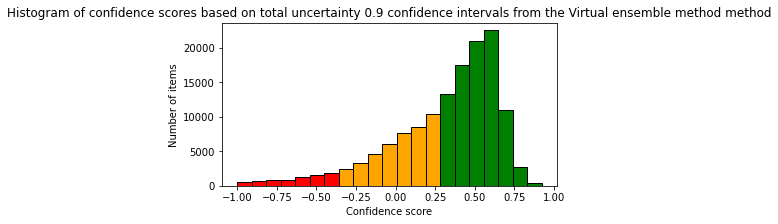

In [130]:
cnts, values = histogram_confidence_score(X_test_ve, 'total uncertainty', 'Virtual ensemble method', 0.9, 21)

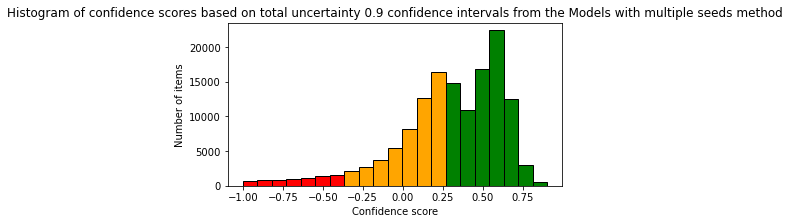

In [131]:
cnts, values = histogram_confidence_score(X_test_s, 'total uncertainty', 'Models with multiple seeds', 0.9, 21)

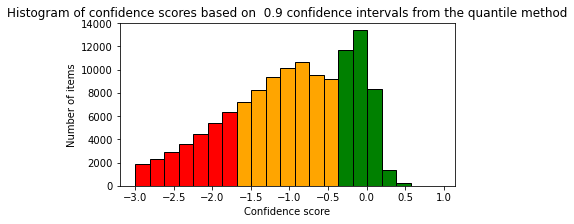

In [132]:
cnts, values = histogram_confidence_score(X_test_q, '', 'quantile', 0.9, 21)

### Results by level

In [133]:
def metric_by(X_test, level='item_id', uncertainty_type='total', percentage=0.9):
    X_test['rmse'] = np.sqrt((X_test['truth'] - X_test['pred'])**2) # rmse
    X_test['fa'] = abs(X_test['truth'] - X_test['pred']) # abs(true - pred)
    
    columns_sum = ['truth', 'pred', 'fa']
    sum_by_item = X_test.groupby(level)[columns_sum].agg(['sum'])
    sum_by_item.columns = columns_sum
    
    # take the mean of rmse per item_id
    mean_by_item = X_test.groupby(level)[['rmse', 'truth', 'confidence_score_90']].agg(['mean'])
    mean_by_item.columns = ['rmse', 'truth_mean', 'confidence_score_90']

    results_by_item=sum_by_item.join(mean_by_item)
    
    results_by_item['fa'] = 1-sum_by_item['fa']/sum_by_item['truth']  # fa
    results_by_item['nrmse'] = mean_by_item['rmse']/mean_by_item['truth_mean'] # normalised rmse
    
    results_by_item = results_by_item[['truth', 'pred', 'fa', 'rmse', 'nrmse', 'confidence_score_90']]

    return results_by_item

In [175]:
results_by_item_s = metric_by(X_test_s, 'item_id')
results_by_item_ve = metric_by(X_test_ve, 'item_id')
results_by_item_q = metric_by(X_test_q, 'item_id')

In [176]:
results_by_item_s.head()

,truth,pred,fa,rmse,nrmse,confidence_score_90
item_id,,,,,,
FOODS_1_045,7404.0,7237.293809,0.689806,4.725668,0.310198,0.480600
FOODS_1_057,1657.0,1673.697987,0.409687,2.587697,0.590419,0.066228
FOODS_1_072,1875.0,1820.893636,0.464432,2.497987,0.535582,0.064107
FOODS_1_085,40416.0,39449.361044,0.811536,15.672739,0.188544,0.737426
FOODS_1_121,3644.0,3495.498820,0.543154,3.425406,0.456721,0.325813


### Explore the correlation of predictions' accuracy / RMSE and uncertainty

In [177]:
def plot_confidence_score_against_accuracy(df, method, percentage=0.9):

    plt.figure(figsize=(8, 4))
    plt.scatter(x=df['confidence_score_90'], y=df['rmse'])
    plt.xlabel('Confidence score by item based on '+ method)
    plt.ylabel('Forecast accuracy by item')
    plt.title('Scatter plot of RMSE per item with respect to confidence score per item based on ' + method)
    plt.show()
    correlation = df['confidence_score_90'].corr(df['rmse']) # pearson's correlation
    print('Pearson correlation between RMSE and confidence score based on ' + method + ' :', correlation.round(decimals=2))

    plt.figure(figsize=(8, 4))
    plt.scatter(x=df['confidence_score_90'], y=df['nrmse'])
    plt.xlabel('Confidence score by item based on '+ method)
    plt.ylabel('Forecast accuracy by item')
    plt.title('Scatter plot of NRMSE per item with respect to confidence score per item based on ' + method)
    plt.show()
    correlation = df['confidence_score_90'].corr(df['nrmse']) # pearson's correlation
    print('Pearson correlation between NRMSE and confidence score based on ' + method + ' :', correlation.round(decimals=2))

    plt.figure(figsize=(8, 4))
    plt.scatter(x=df['confidence_score_90'], y=df['fa'])
    plt.xlabel('Confidence score by item based on '+ method)
    plt.ylabel('Forecast accuracy by item')
    plt.title('Scatter plot of FA per item with respect to confidence score per item based on ' + method)
    plt.show()
    
    correlation = df['confidence_score_90'].corr(df['fa']) # pearson's correlation
    print('Pearson correlation between FA and confidence score based on ' + method + ' :', correlation.round(decimals=2))
    

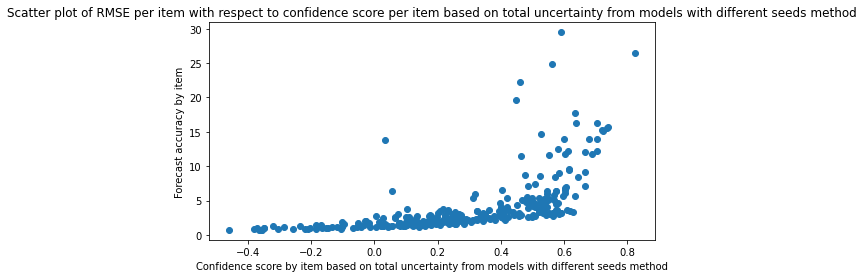

Pearson correlation between RMSE and confidence score based on total uncertainty from models with different seeds method : 0.59


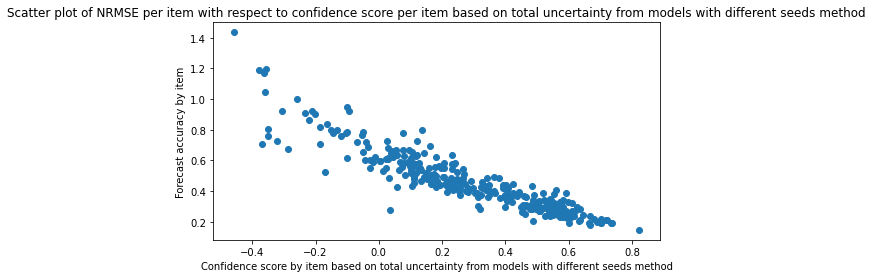

Pearson correlation between NRMSE and confidence score based on total uncertainty from models with different seeds method : -0.91


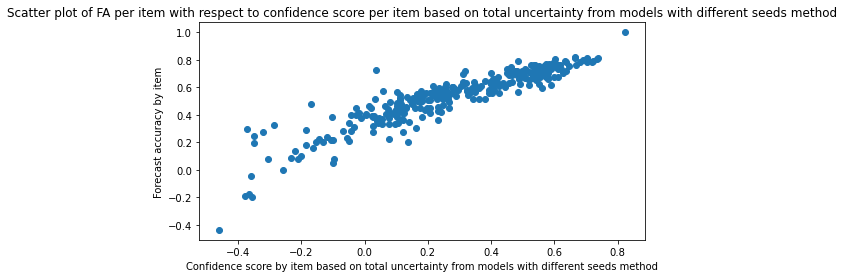

Pearson correlation between FA and confidence score based on total uncertainty from models with different seeds method : 0.91


In [178]:
plot_confidence_score_against_accuracy(results_by_item_s, 'total uncertainty from models with different seeds method')

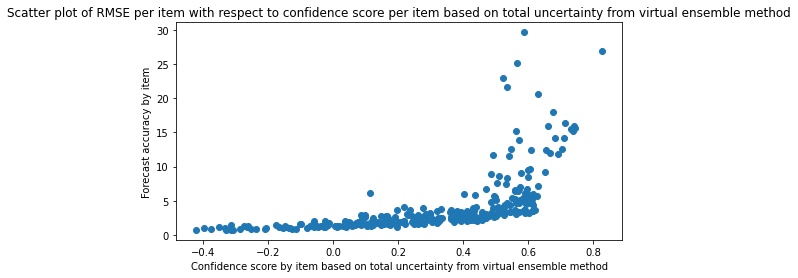

Pearson correlation between RMSE and confidence score based on total uncertainty from virtual ensemble method : 0.59


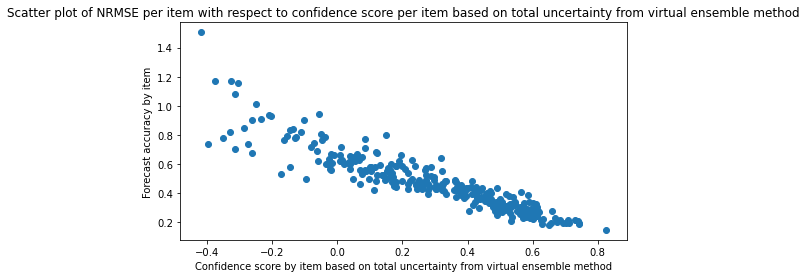

Pearson correlation between NRMSE and confidence score based on total uncertainty from virtual ensemble method : -0.92


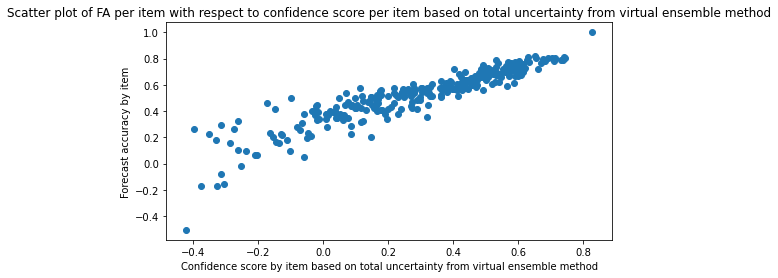

Pearson correlation between FA and confidence score based on total uncertainty from virtual ensemble method : 0.92


In [179]:
plot_confidence_score_against_accuracy(results_by_item_ve, 'total uncertainty from virtual ensemble method')

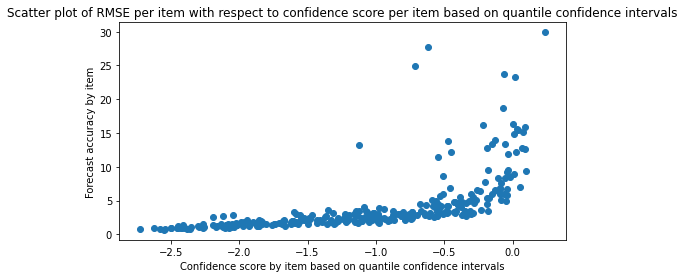

Pearson correlation between RMSE and confidence score based on quantile confidence intervals : 0.61


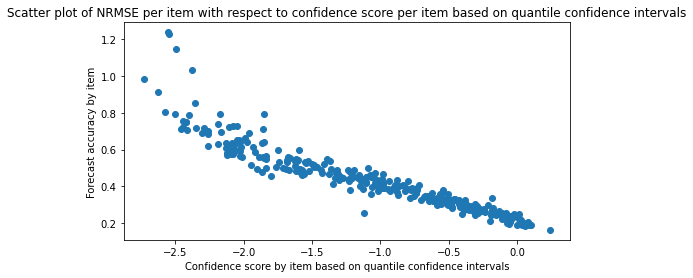

Pearson correlation between NRMSE and confidence score based on quantile confidence intervals : -0.93


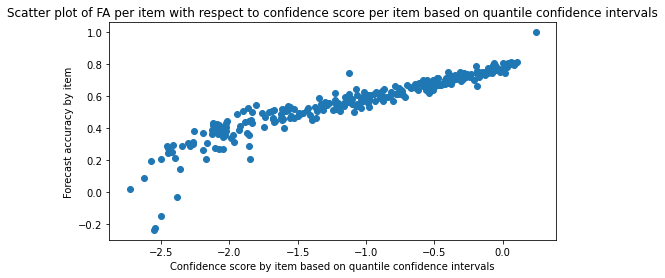

Pearson correlation between FA and confidence score based on quantile confidence intervals : 0.93


In [180]:
plot_confidence_score_against_accuracy(results_by_item_q, 'quantile confidence intervals')

In [169]:
def quantile_plot(nb_bins, df, method, percentage_ci=0.9):
 
    x = df['confidence_score_90']
    #create category based on quantile of confidence scores
    df['confidence_score_category'] = pd.qcut(x, nb_bins, labels=False)

    #labels items by the quantile of their uncertainty kpi 
    agg = df.groupby(['confidence_score_category'], as_index=False)[['truth', 'rmse', 'nrmse', 'fa', 'confidence_score_90']].mean()
    
    plt.figure(figsize = (8,4))
    plt.plot(np.arange(nb_bins), agg['rmse'], color='#002244', label='RMSE')
    for i,j in zip(np.arange(nb_bins),agg['rmse']):
        plt.annotate(str(np.array(j).round(decimals=2)),xy=(i,j), xytext =(i-0.1, j))
    plt.xlabel('Confidence scores category')
    plt.ylabel('Mean of RMSE per category')
    plt.title("Plot of RMSE per category of confidence score based on" + method)
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (8,4))
    plt.plot(np.arange(nb_bins), agg['nrmse'], color='#66cccc', label='NRMSE')
    for i,j in zip(np.arange(nb_bins),agg['nrmse']):
        plt.annotate(str(np.array(j).round(decimals=2)),xy=(i,j), xytext =(i-0.1, j))
    plt.xlabel('Order of confidence scores')
    plt.ylabel('Mean of NRMSE per bin')
    plt.title("Plot of NRMSE per category of confidence score based on" + method)
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (8,4))
    plt.plot(np.arange(nb_bins), agg['fa'], color='#ff0066', label='Forecast Accuracy')
    for i,j in zip(np.arange(nb_bins),agg['fa']):
        plt.annotate(str(np.array(j).round(decimals=2)),xy=(i,j), xytext =(i-0.1, j))
    plt.xlabel('Confidence scores category')
    plt.ylabel('Mean of forecast accuracy per category')
    plt.title("Plot of FA per category of confidence score based on" + method)
    plt.legend()
    plt.show()

    plt.figure(figsize = (8,4))
    plt.plot(np.arange(nb_bins), agg['truth'], color='#002244', label='Volumes (true values)')
    for i,j in zip(np.arange(nb_bins),agg['truth']):
        plt.annotate(str(np.array(j).round(decimals=2)),xy=(i,j), xytext =(i-0.1, j))
    plt.xlabel('Confidence scores category')
    plt.ylabel('Mean of sale volumes (true values) per category')
    plt.title("Plot of sale volumes per quantile of confidence score based on" + method)
    plt.legend()
    plt.show()

    return agg

### Performances for forecasts grouped by item

##### Dataset aggregated by item_id

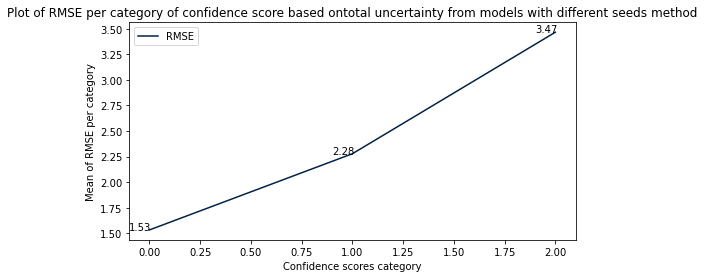

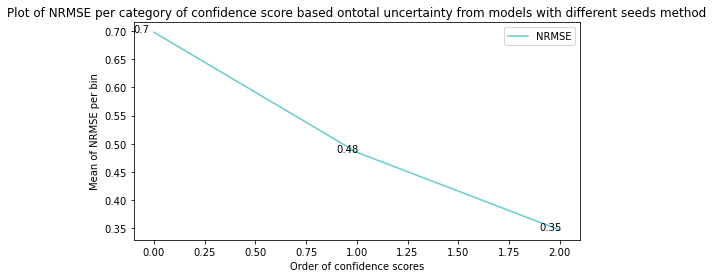

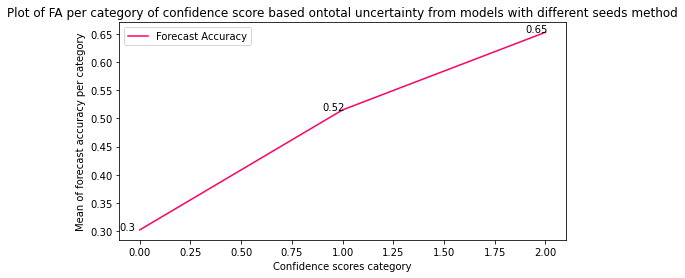

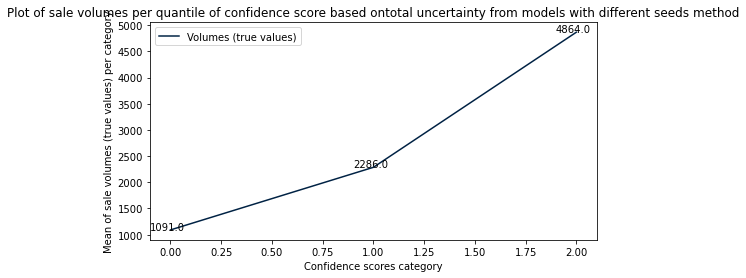

In [170]:
df_sum_s = quantile_plot(3, results_by_item_s[results_by_item_s['truth']<8000], 'total uncertainty from models with different seeds method')

In [171]:
df_sum_s

,confidence_score_category,truth,rmse,nrmse,fa,confidence_score_90
0,0,1091.0,1.532908,0.697914,0.302082,-0.053208
1,1,2286.0,2.277657,0.484950,0.515043,0.219157
2,2,4864.0,3.465319,0.347281,0.652719,0.471376


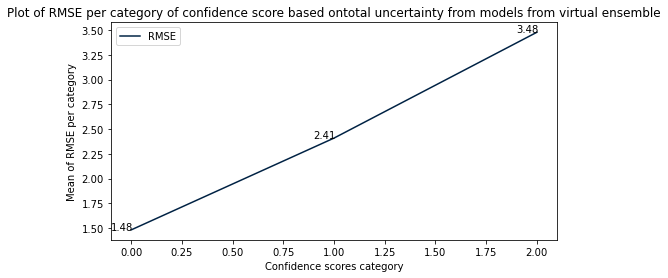

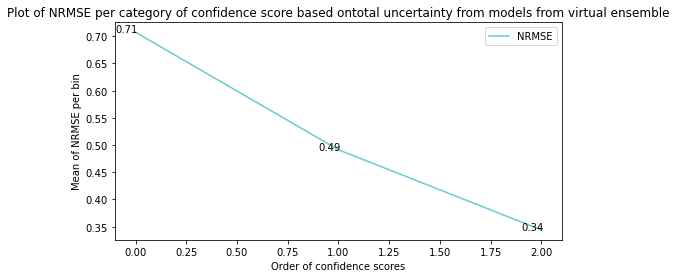

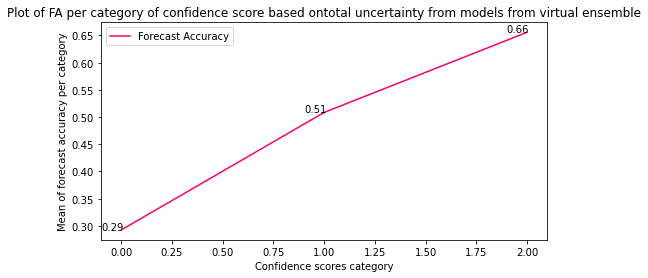

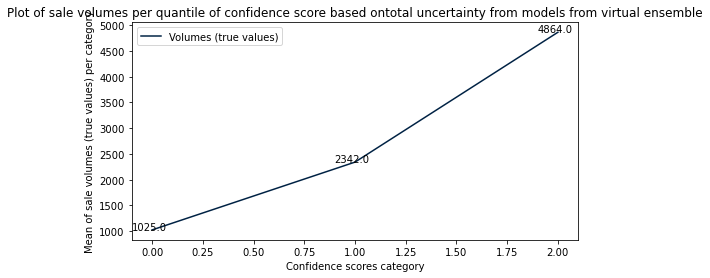

In [172]:
df_sum_ve = quantile_plot(3, results_by_item_ve[results_by_item_ve['truth']<8000], 'total uncertainty from models from virtual ensemble')

In [173]:
df_sum_ve

,confidence_score_category,truth,rmse,nrmse,fa,confidence_score_90
0,0,1025.0,1.482008,0.707456,0.292542,-0.057727
1,1,2342.0,2.409586,0.491425,0.508584,0.264129
2,2,4864.0,3.478776,0.344054,0.655942,0.492775


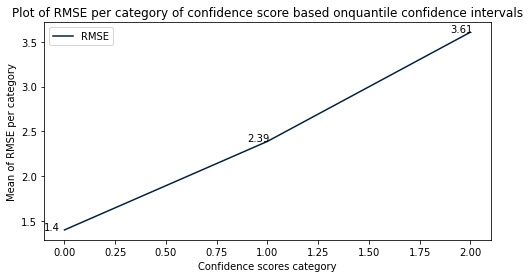

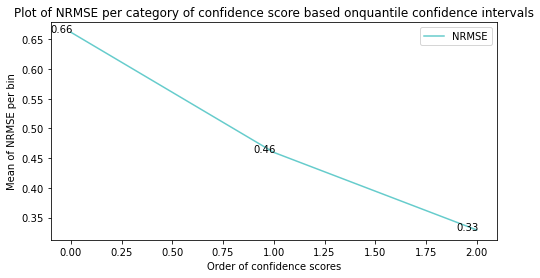

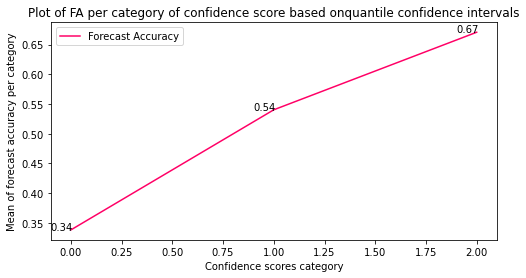

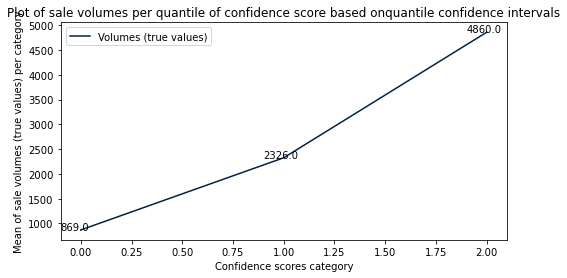

In [174]:
df_sum_q = quantile_plot(3, results_by_item_q[results_by_item_q['truth']<8000], 'quantile confidence intervals')

In [150]:
df_sum_q

,confidence_score_category,truth,rmse,nrmse,fa,confidence_score_90
0,0,1048.0,1.543508,0.633284,0.366730,-1.977592
1,1,2898.0,3.226656,0.414011,0.585990,-1.009544
2,2,5732.0,7.463210,0.270274,0.731358,-0.254066


The NRMSE and FA plots are coherent, but the RMSE should have decreasing RMSE as the confidence score increases. This is explained by the non-normalisation of the RMSE. Indeed the volumes are higher for higher confidence score, therefore the RMSE is also high. 

### Metrics from paper

Prediction Rejection Ration (PRR) measures how well uncertainty estimates correlate with errors and rank-order them.

PRR is based on the hypothesis correlation of uncertainty and errors.
We plot two ROC curves:
- Blue ROC curve: the relative difference between the MSE and the MSE of first predictions ordered with smallest errors and the rest being true values
- Red ROC curve: the relative difference between the MSE and the MSE of first predictions ordered with smallest uncertainty and the rest being true values

The PRR is then computed as the red area over the blue area.
$$\text{AUC RR} = \frac{\text{var auc} - \text{min auc}}{\text{max auc} - \text{min auc}} = \frac{\text{red area}}{\text{blue area}}$$

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [ ]:
def prr_regression(targets, preds, measure, pos_label=1):
    if pos_label != 1:
        measure_loc = -1.0 * measure
    else:
        measure_loc = measure
    preds = np.squeeze(preds)
    # Compute total MSE
    error = (preds - targets) ** 2
    MSE_0 = np.mean(error)

    # Create array
    array = np.concatenate(
        (preds[:, np.newaxis], targets[:, np.newaxis], error[:, np.newaxis], measure_loc[:, np.newaxis]), axis=1)

    # Results arrays: used to create AUC_RR curve
    results_max = [[0.0, 0.0]]
    results_var = [[0.0, 0.0]]
    results_min = [[0.0, 0.0]]

    optimal_ranking = array[:, 2].argsort()
    sorted_array = array[optimal_ranking]  # Sort by error

    for i in range(1, array.shape[0]):
        # predictions (from smallest error to biggest) with last i values are the true values
        x = np.concatenate((sorted_array[:-i, 0], sorted_array[-i:, 1]), axis=0)
        mse = np.mean((x - sorted_array[:, 1]) ** 2)
        # Best rejection: used to plot ROC curve
        results_max.append([float(i) / float(array.shape[0]), (MSE_0 - mse) / MSE_0])
        # Random Rejection: plot y=x corresponds to random
        results_min.append([float(i) / float(array.shape[0]), float(i) / float(array.shape[0])])

    #repeat similar steps with sorted uncertainty
        
    uncertainty_ranking = array[:, 3].argsort()
    sorted_array = array[uncertainty_ranking]  # Sort by uncertainty

    for i in range(1, array.shape[0]):
        # predictions (from smallest uncertainty to biggest) with last i values are the true values
        x = np.concatenate((sorted_array[:-i, 0], sorted_array[-i:, 1]), axis=0)
        mse = np.mean((x - sorted_array[:, 1]) ** 2)
        results_var.append([float(i) / float(array.shape[0]), (MSE_0 - mse) / MSE_0])

    # compute Area Under Curve: auc(recall, precision)
    max_auc = auc([x[0] for x in results_max], [x[1] for x in results_max])
    var_auc = auc([x[0] for x in results_var], [x[1] for x in results_var])
    min_auc = auc([x[0] for x in results_min], [x[1] for x in results_min])

    # compute Rejection Ratio
    AUC_RR = (var_auc - min_auc) / (max_auc - min_auc)

    return AUC_RR, results_max, results_var, results_min


In [ ]:
def normal_KL(params1, params2, epsilon=1e-20):
    mu_1 = params1[0]
    mu_2 = params2[0]

    logvar1 = np.log(params1[1] + epsilon)
    logvar2 = np.log(params2[1] + epsilon)

    mean_term = 0.5 * np.exp(2 * np.log(np.abs(mu_1 - mu_2)) - logvar2)
    sigma_term = 0.5 * (np.exp(logvar1 - logvar2) - 1.0 + logvar2 - logvar1)

    return mean_term + sigma_term


def epkl_reg(preds):
    """
    preds: array [n_samples, n_models, 2]
    """
    M = preds.shape[1]
    EPKL = []
    for pred in preds:
        epkl = 0.0
        for i, pr1 in enumerate(pred):
            for j, pr2 in enumerate(pred):
                if i != j:
                    epkl += normal_KL(pr1, pr2)

        epkl = epkl / (M * (M - 1))
        EPKL.append(epkl)
    return np.asarray(EPKL)

In [ ]:
def ensemble_uncertainties_regression(preds):
    """
    preds: array [n_samples, n_models, 2] - last dim ins mean, var
    """
    epkl = epkl_reg(preds)

    var_mean = np.var(preds[:, :, 0], axis=1)
    mean_var = np.mean(preds[:, :, 1], axis=1)

    uncertainty = {'tvar': var_mean + mean_var,
                   'mvar': mean_var,
                   'varm': var_mean,
                   'epkl': epkl}

    return uncertainty

The function from the paper is only adapted to the second model because of the structure of the results.

In [ ]:
TU = ensemble_uncertainties_regression(np.swapaxes(preds_10, 0, 1))["tvar"]
KU = ensemble_uncertainties_regression(np.swapaxes(preds_10, 0, 1))["varm"]

In [ ]:
from collections import defaultdict

values = defaultdict(lambda: [])

tu_prr_output = prr_regression(y_test, mean_preds_10, TU)
values["TU_prr"]=tu_prr_output[0]
ku_prr_output = prr_regression(y_test, mean_preds_10, KU)
values["KU_prr"]=ku_prr_output[0]

In [ ]:
print('Total Uncertity PRR: ', values["TU_prr"])
print('Knowledge Uncertity PRR: ', values["KU_prr"])

Total Uncertity PRR:  0.8933106965664819
Knowledge Uncertity PRR:  0.8689806996794168


As compared to the datasets' results from the paper, these results imply that the errors and the uncertainties are highly correlated. 

We can plot the ROC curves: 

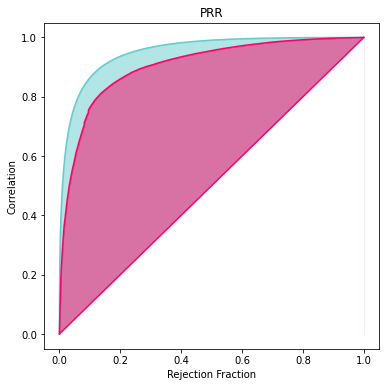

In [ ]:
tu_max, tu_var, tu_min = tu_prr_output[1:]

plt.figure(figsize=(6,6))
plt.plot([x[0] for x in tu_max], [x[1] for x in tu_max], color = '#66cccc')
plt.fill_between([x[0] for x in tu_max], [x[1] for x in tu_max], color='#66cccc', alpha=0.5)
plt.plot([x[0] for x in tu_var], [x[1] for x in tu_var], color = '#ff0066')
plt.fill_between([x[0] for x in tu_var], [x[1] for x in tu_var], color = '#ff0066', alpha=0.5)
plt.plot([x[0] for x in tu_min], [x[1] for x in tu_min], color = '#ff0066')
plt.fill_between([x[0] for x in tu_min], [x[1] for x in tu_min], color = 'white')
plt.xlabel('Rejection Fraction')
plt.ylabel('Correlation')
plt.title('PRR')
plt.show()